In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# load dataset
data = pd.read_csv('Restaurant reviews.csv')

# only relevant columns keep
data = data[['Review', 'Rating']]

# 'Rating' to numeric-  force errors to NaN
data['Rating'] = pd.to_numeric(data['Rating'], errors='coerce')

# clean dataset
def preprocess_text(text):
    if pd.isnull(text):  # check for NaN
        return ""
    # lowercase
    text = text.lower()
    # remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # tkenize, remove stop words
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# apply preprocessing
data['Cleaned_Review'] = data['Review'].apply(preprocess_text)


In [4]:
# sentiment labels based on ratings
data['Sentiment'] = data['Rating'].apply(lambda x: 'Positive' if x > 3 else 'Negative')
data['Sentiment'] = data['Sentiment'].map({'Positive': 1, 'Negative': 0})

# split data
X = data['Cleaned_Review']
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tokenize and pad seq
max_words = 10000  # numb of unique words to consider
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [5]:
# diff configurations for ablation study, hyperparameters+architecture variations
ablation_configs = [
    {"embedding_dim": 64, "rnn_type": "LSTM", "num_layers": 1, "units": 32, "dropout": 0.2, "max_len": 100, "learning_rate": 0.001},
    {"embedding_dim": 128, "rnn_type": "LSTM", "num_layers": 2, "units": 64, "dropout": 0.3, "max_len": 100, "learning_rate": 0.001},
    {"embedding_dim": 128, "rnn_type": "GRU", "num_layers": 1, "units": 64, "dropout": 0.2, "max_len": 50, "learning_rate": 0.0003},
    {"embedding_dim": 256, "rnn_type": "LSTM", "num_layers": 2, "units": 128, "dropout": 0.5, "max_len": 100, "learning_rate": 0.0005},
    {"embedding_dim": 128, "rnn_type": "Bidirectional_LSTM", "num_layers": 1, "units": 64, "dropout": 0.2, "max_len": 150, "learning_rate": 0.0008},
    {"embedding_dim": 128, "rnn_type": "Bidirectional_GRU", "num_layers": 1, "units": 64, "dropout": 0.2, "max_len": 200, "learning_rate": 0.001},
]

results = []

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# loop through configurations
for idx, config in enumerate(ablation_configs):
    print(f"\nRunning Configuration {idx+1}: {config}")

    # pad seq based on max_len
    X_train_pad = pad_sequences(X_train_seq, maxlen=config['max_len'])
    X_test_pad = pad_sequences(X_test_seq, maxlen=config['max_len'])

    # build model based on configuration
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=config['embedding_dim'], input_length=config['max_len']))

    for layer in range(config['num_layers']):
        if config['rnn_type'] == "LSTM":
            model.add(LSTM(units=config['units'], dropout=config['dropout'], recurrent_dropout=config['dropout'], return_sequences=(layer < config['num_layers'] - 1)))
        elif config['rnn_type'] == "GRU":
            model.add(GRU(units=config['units'], dropout=config['dropout'], recurrent_dropout=config['dropout'], return_sequences=(layer < config['num_layers'] - 1)))
        elif config['rnn_type'] == "Bidirectional_LSTM":
            model.add(Bidirectional(LSTM(units=config['units'], dropout=config['dropout'], recurrent_dropout=config['dropout'], return_sequences=(layer < config['num_layers'] - 1))))
        elif config['rnn_type'] == "Bidirectional_GRU":
            model.add(Bidirectional(GRU(units=config['units'], dropout=config['dropout'], recurrent_dropout=config['dropout'], return_sequences=(layer < config['num_layers'] - 1))))

    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer=Adam(learning_rate=config['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    # Train model with early stopping
    history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # evaluate model
    y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True)
    matrix = confusion_matrix(y_test, y_pred)

    # save model with unique filename based on configuration
    model_filename = f"{config['rnn_type']}_emb{config['embedding_dim']}_layers{config['num_layers']}_units{config['units']}_drop{int(config['dropout']*100)}_len{config['max_len']}_lr{str(config['learning_rate']).replace('.', '')}.h5"
    model.save(model_filename)
    print(f"Model saved as {model_filename}")

    # save results
    results.append({
        "Config": config,
        "Model Filename": model_filename,
        "Classification Report": report,
        "Confusion Matrix": matrix
    })

    # print summary of each configuration
    print(f"\nResults for Configuration {idx+1}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(matrix)


Running Configuration 1: {'embedding_dim': 64, 'rnn_type': 'LSTM', 'num_layers': 1, 'units': 32, 'dropout': 0.2, 'max_len': 100, 'learning_rate': 0.001}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 120ms/step - accuracy: 0.6780 - loss: 0.5940 - val_accuracy: 0.8612 - val_loss: 0.3444
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.8839 - loss: 0.2945 - val_accuracy: 0.8637 - val_loss: 0.3347
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.9194 - loss: 0.2126 - val_accuracy: 0.8569 - val_loss: 0.3670
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.9465 - loss: 0.1451 - val_accuracy: 0.8494 - val_loss: 0.4108
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


Model saved as LSTM_emb64_layers1_units32_drop20_len100_lr0001.h5

Results for Configuration 1:
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       729
           1       0.90      0.89      0.89      1271

    accuracy                           0.87      2000
   macro avg       0.85      0.86      0.86      2000
weighted avg       0.87      0.87      0.87      2000

Confusion Matrix:
[[ 600  129]
 [ 140 1131]]

Running Configuration 2: {'embedding_dim': 128, 'rnn_type': 'LSTM', 'num_layers': 2, 'units': 64, 'dropout': 0.3, 'max_len': 100, 'learning_rate': 0.001}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - accuracy: 0.6770 - loss: 0.5734 - val_accuracy: 0.8550 - val_loss: 0.3403
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.8891 - loss: 0.2749 - val_accuracy: 0.8500 - val_loss: 0.3511
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step


Model saved as LSTM_emb128_layers2_units64_drop30_len100_lr0001.h5

Results for Configuration 2:
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       729
           1       0.86      0.94      0.90      1271

    accuracy                           0.86      2000
   macro avg       0.87      0.83      0.84      2000
weighted avg       0.86      0.86      0.86      2000

Confusion Matrix:
[[ 528  201]
 [  76 1195]]

Running Configuration 3: {'embedding_dim': 128, 'rnn_type': 'GRU', 'num_layers': 1, 'units': 64, 'dropout': 0.2, 'max_len': 50, 'learning_rate': 0.0003}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.6398 - loss: 0.6503 - val_accuracy: 0.8012 - val_loss: 0.5242
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8400 - loss: 0.4418 - val_accuracy: 0.8150 - val_loss: 0.4406
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


Model saved as GRU_emb128_layers1_units64_drop20_len50_lr00003.h5

Results for Configuration 3:
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       729
           1       0.80      0.93      0.86      1271

    accuracy                           0.81      2000
   macro avg       0.82      0.76      0.78      2000
weighted avg       0.81      0.81      0.80      2000

Confusion Matrix:
[[ 432  297]
 [  86 1185]]

Running Configuration 4: {'embedding_dim': 256, 'rnn_type': 'LSTM', 'num_layers': 2, 'units': 128, 'dropout': 0.5, 'max_len': 100, 'learning_rate': 0.0005}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 241ms/step - accuracy: 0.6542 - loss: 0.6242 - val_accuracy: 0.8300 - val_loss: 0.3768
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - accuracy: 0.8454 - loss: 0.3499 - val_accuracy: 0.8600 - val_loss: 0.3393
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step


Model saved as LSTM_emb256_layers2_units128_drop50_len100_lr00005.h5

Results for Configuration 4:
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       729
           1       0.83      0.91      0.87      1271

    accuracy                           0.83      2000
   macro avg       0.83      0.80      0.81      2000
weighted avg       0.83      0.83      0.83      2000

Confusion Matrix:
[[ 498  231]
 [ 110 1161]]

Running Configuration 5: {'embedding_dim': 128, 'rnn_type': 'Bidirectional_LSTM', 'num_layers': 1, 'units': 64, 'dropout': 0.2, 'max_len': 150, 'learning_rate': 0.0008}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 324ms/step - accuracy: 0.6732 - loss: 0.5763 - val_accuracy: 0.8425 - val_loss: 0.3555
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 321ms/step - accuracy: 0.8949 - loss: 0.2736 - val_accuracy: 0.8537 - val_loss: 0.3629
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step


Model saved as Bidirectional_LSTM_emb128_layers1_units64_drop20_len150_lr00008.h5

Results for Configuration 5:
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       729
           1       0.84      0.95      0.89      1271

    accuracy                           0.85      2000
   macro avg       0.86      0.82      0.83      2000
weighted avg       0.86      0.85      0.85      2000

Confusion Matrix:
[[ 503  226]
 [  68 1203]]

Running Configuration 6: {'embedding_dim': 128, 'rnn_type': 'Bidirectional_GRU', 'num_layers': 1, 'units': 64, 'dropout': 0.2, 'max_len': 200, 'learning_rate': 0.001}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 100s 487ms/step - accuracy: 0.6586 - loss: 17781344.0000 - val_accuracy: 0.7725 - val_loss: 0.5100
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 477ms/step - accuracy: 0.8189 - loss: 80.8884 - val_accuracy: 0.7912 - val_loss: 0.4823
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step


Model saved as Bidirectional_GRU_emb128_layers1_units64_drop20_len200_lr0001.h5

Results for Configuration 6:
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.48      0.61       729
           1       0.76      0.95      0.84      1271

    accuracy                           0.78      2000
   macro avg       0.80      0.71      0.73      2000
weighted avg       0.79      0.78      0.76      2000

Confusion Matrix:
[[ 349  380]
 [  67 1204]]


In [6]:
# summary of all configurations
print("\n\nAblation Study Results Summary:")
for idx, result in enumerate(results):
    print(f"\nConfiguration {idx+1}: {result['Config']}")
    print("Model saved as:", result['Model Filename'])
    print("Classification Report:", result['Classification Report'])
    print("Confusion Matrix:", result['Confusion Matrix'])



Ablation Study Results Summary:

Configuration 1: {'embedding_dim': 64, 'rnn_type': 'LSTM', 'num_layers': 1, 'units': 32, 'dropout': 0.2, 'max_len': 100, 'learning_rate': 0.001}
Model saved as: LSTM_emb64_layers1_units32_drop20_len100_lr0001.h5
Classification Report: {'0': {'precision': 0.8108108108108109, 'recall': 0.823045267489712, 'f1-score': 0.8168822328114363, 'support': 729.0}, '1': {'precision': 0.8976190476190476, 'recall': 0.8898505114083399, 'f1-score': 0.8937178980640064, 'support': 1271.0}, 'accuracy': 0.8655, 'macro avg': {'precision': 0.8542149292149293, 'recall': 0.856447889449026, 'f1-score': 0.8553000654377214, 'support': 2000.0}, 'weighted avg': {'precision': 0.8659774453024454, 'recall': 0.8655, 'f1-score': 0.8657112980794446, 'support': 2000.0}}
Confusion Matrix: [[ 600  129]
 [ 140 1131]]

Configuration 2: {'embedding_dim': 128, 'rnn_type': 'LSTM', 'num_layers': 2, 'units': 64, 'dropout': 0.3, 'max_len': 100, 'learning_rate': 0.001}
Model saved as: LSTM_emb128_l

In [8]:
# Print only accuracies for each configuration
print("Ablation Study - Accuracies for Each Configuration:")
for idx, result in enumerate(results):
    config = result['Config']
    accuracy = result['Classification Report']['accuracy']
    print(f"Configuration {idx + 1} (Type: {config['rnn_type']}, Layers: {config['num_layers']}): Accuracy = {accuracy:.4f}")


Ablation Study - Accuracies for Each Configuration:
Configuration 1 (Type: LSTM, Layers: 1): Accuracy = 0.8655
Configuration 2 (Type: LSTM, Layers: 2): Accuracy = 0.8615
Configuration 3 (Type: GRU, Layers: 1): Accuracy = 0.8085
Configuration 4 (Type: LSTM, Layers: 2): Accuracy = 0.8295
Configuration 5 (Type: Bidirectional_LSTM, Layers: 1): Accuracy = 0.8530
Configuration 6 (Type: Bidirectional_GRU, Layers: 1): Accuracy = 0.7765


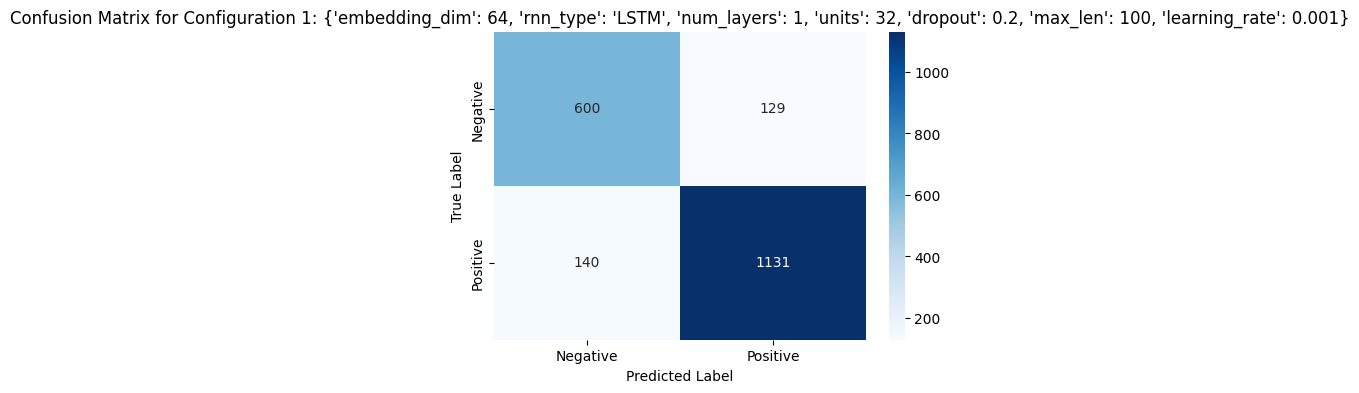

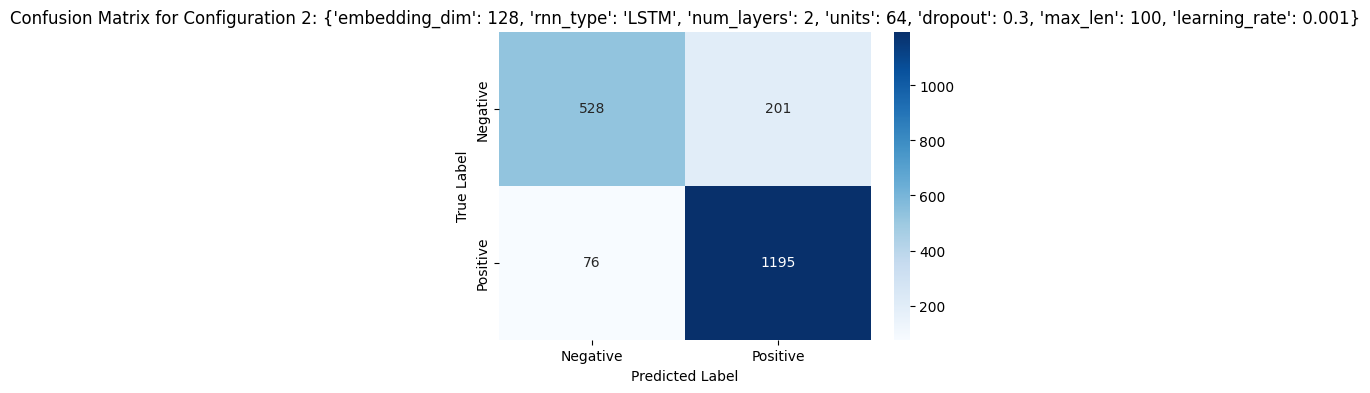

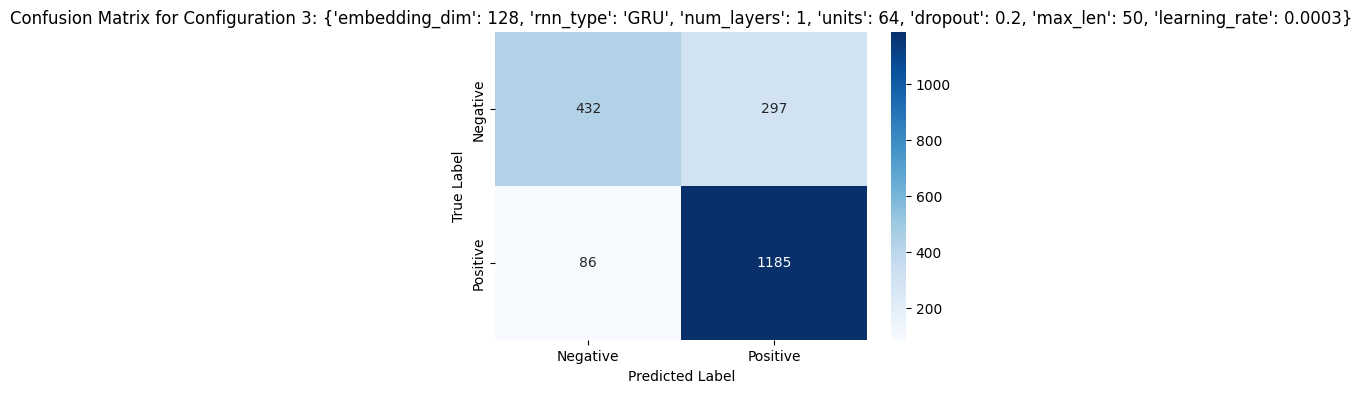

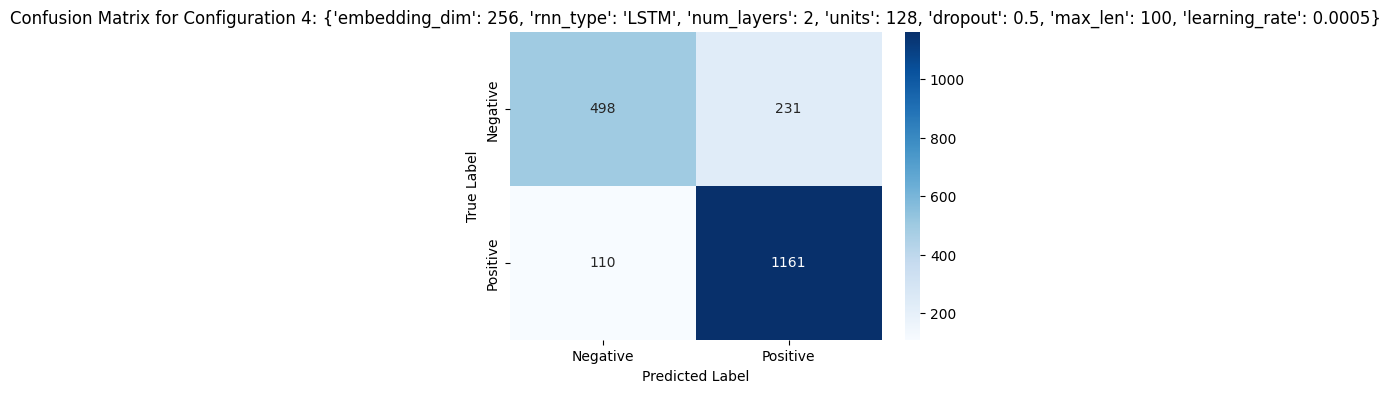

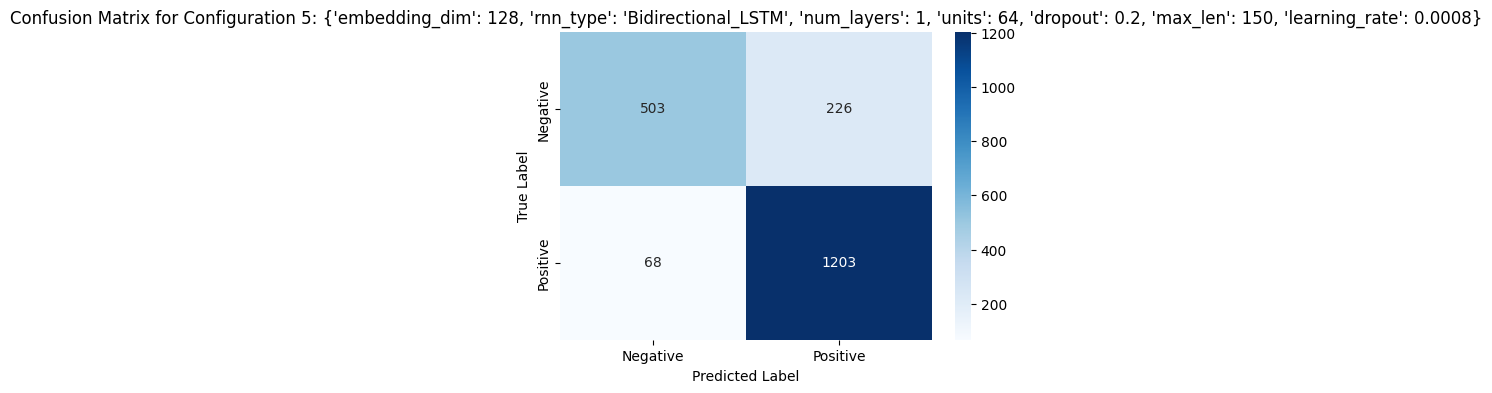

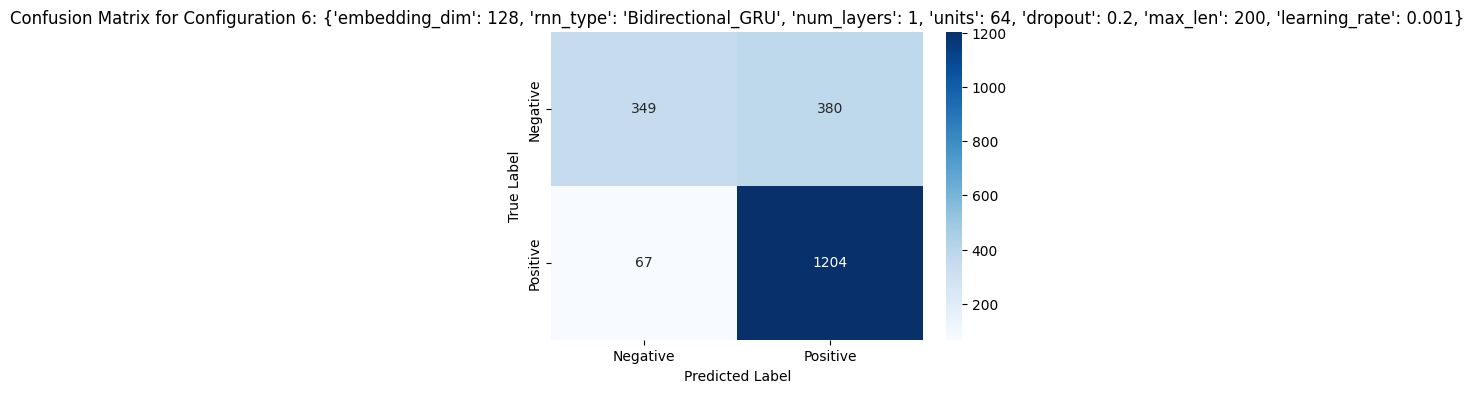

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Visualize confusion matrices for all configurations in the results list
for idx, result in enumerate(results):
    cm = result['Confusion Matrix']
    title = f"Confusion Matrix for Configuration {idx+1}: {result['Config']}"
    plot_confusion_matrix(cm, title)
